# Setup

`TRAINING_RANGE` und `TEST_RANGE` müssen je nach Länge des Datensatzes angepasst werden.

**Keine Anpassung erforderlich** (Siehe Datensatz herunterladen)
- 30% Training-Daten (0-30%)
- 70% Test-Daten (30%-100%)

In [1]:
INPUT_FILE = 'data.csv'
TARGET_COLUMN = 'flt_obd_speed'
# Still contains positional information and acceleration; however we currently train
# sample by sample without knowledge of previous or other data, so it should not be
# possible for the Regressor to simply "calculate" the speed.
EXCLUDED_COLUMNS = ('flt_gps_speed', 'flt_obd_engine_load', 'flt_obd_engine_rpm',
                    'flt_obd_maf', 'flt_obd_accelerator_pedal','flt_time','flt_time_system_clock',
                    'flt_time_utc','flt_ax','flt_ay','flt_az','flt_gx','flt_gy','flt_gz','flt_compass',
                    'flt_number_of_satelites','flt_accuracy','flt_gps_bearing','flt_calc_dist_gps',
                    'flt_calc_dist_vt','flt_calc_ax_vt','flt_timeIP',
                    'weat_latitude','weat_longitude','weat_distanceIP','weat_timeIP','weat_join_idx',
                    'hAccel_1','hAccel_2','hAccel_3','flt_mAccel_1','flt_mAccel_2','flt_mAccel_3',
                    'flt_mGier_1','flt_mGier_2','flt_mGier_3','rot_Accel_1','rot_Accel_2','rot_Accel_3',
                    'rot_Gier_1','rot_Gier_2','rot_Gier_3','rot_Accel_flt_1','rot_Accel_flt_2','rot_Accel_flt_3',
                    'rot_Gier_flt_1','rot_Gier_flt_2','rot_Gier_flt_3'
                   )
# See explanation below the feature importance plot
OVERFITTING_COLUMNS = ('weat_temperature', 'weat_humidity', 'join_idx', 'weat_windBearing', 'weat_windSpeed',
                       'latitude', 'longitude', 'flt_latitude', 'flt_longitude',
                       'ors_percentage_cumsum', 'flt_obd_air_temperature',
                       'mb_step_weight')
# Since there are a lot of fields containing those
# Note: This breaks the map plotting
OVERFITTING_SUBWORDS = ('distance', 'remainDistance', 'remainDistanze', 'cumsumDistance', 'segDistance', 'time', 'remainTime')

from runsql import runsql
DATA_COLUMNS = [c['Field']
                for c in runsql('show columns from computeddata')
                if c['Type'] == 'double'
                and c['Field'] != TARGET_COLUMN
                and c['Field'] not in EXCLUDED_COLUMNS
                and c['Field'] not in OVERFITTING_COLUMNS
                and not any([w in c['Field'] for w in OVERFITTING_SUBWORDS])]
len(DATA_COLUMNS)

311

# Datensatz herunterladen

`SETUP_ID` anpassen, Rest läuft automatisch.

Einige Datensätze besitzen keinen Eintrag für `flt_obd_speed`. Für eine Liste der Datensätze *mit* diesem Wert kann beispielsweise folgende SQL-Abfrage verwendet werden (Achtung, braucht (prinzipbedingt) sehr lange!):

```sql
select setup_id s, count(*) n
from computeddata
group by s
having not exists (
    select *
    from computeddata
    where setup_id = s
    and flt_obd_speed is null)
order by n asc
```

In [2]:
SETUP_ID = 868
import csv
from runsql import runsql
reader = runsql('select * from computeddata where setup_id = {} order by distance asc'.format(SETUP_ID))
reader_data = list(reader) # list(...) so that following cells can be repeated

In [3]:
import math
data = []
target = []
for row in reader_data:
    data += [[float(row[c]) if row[c] != '' else math.nan for c in DATA_COLUMNS]]
    target += [float(row[TARGET_COLUMN])] # Errors if NaN in TARGET_COLUMN

In [4]:
tr_st = 0
tr_ed = math.floor(len(data)*0.3)
TRAINING_RANGE = (tr_st, tr_ed)
TEST_RANGE = (tr_ed, len(data)) # TEST_RANGE = (len(data)-tr_ed, len(data))

# Leere Zellen füllen

Da nicht alle Datensätze alle Spalten haben – gäbe sicherlich bessere Strategien, aber das funktioniert erstaunlich gut (wahrscheinlich sind die "wichtigen" Spalten immer vorhanden).

In [5]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='constant', fill_value=0) # Other strategies remove fully null columns
data = imp.fit_transform(data)
import numpy as np
np.shape(data)

(7228, 311)

# Analyze INPUT DATA
Eingangsdaten analysieren

In [6]:
# Convert to Table
import sys
from astropy.table import Table
t = Table(data, names=DATA_COLUMNS)
lat = t['latitude']
lng = t['longitude']
# Subsampling ... use points every 50m for plotting
lat = lat[::10]
lng = lng[::10]
# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lng) - margin
lon_max = max(lng) + margin
t

KeyError: 'latitude'

In [10]:
# Calculation ZOOM LEVEL
width  = 640
height = 640
tileSize= 256*4

# Converts given lat/lon in WGS84 Datum to XY in Spherical Mercator EPSG:900913"
originShift = 2 * math.pi * 6378137/2.0; # 20037508.342789244
xExtent_min = lon_min * originShift / 180;
yExtent_min = math.log(math.tan((90 + lat_min) * math.pi / 360 )) / (math.pi / 180);
yExtent_min = yExtent_min * originShift / 180;
xExtent_max = lon_max * originShift / 180;
yExtent_max = math.log(math.tan((90 + lat_max) * math.pi / 360 )) / (math.pi / 180);
yExtent_max = yExtent_max * originShift / 180;

minResX = (xExtent_max-xExtent_min)/width;
minResY = (yExtent_max-yExtent_min)/height;
minRes  = max([minResX, minResY]);
initialResolution = 2 * math.pi * 6378137 / tileSize; # 156543.03392804062 for tileSize 256 pixels
zoomlevel = math.floor(math.log2(initialResolution/minRes));

# Enforce valid zoom levels
if zoomlevel < 0:
    zoomlevel = 0
if zoomlevel > 19: 
    zoomlevel = 19

NameError: name 'lon_min' is not defined

In [11]:
# Analyze Data
import plotly
import plotly.graph_objs as go
import plotly.plotly as py

plotly.tools.set_credentials_file(username='ziegmann', api_key='yGii8dk78Sjz7jzzad1n')
mapbox_access_token = 'pk.eyJ1Ijoiam9oYW5ubmVzLXppZWdtYW5uIiwiYSI6ImNqbDJmamo5bDFxNjQzcWxtd2IzejNhcXoifQ.iVXGH-jpe2FH3f52MM9yHQ'

data_p = [
    go.Scattermapbox(
        lat=lat,
        lon=lng,
        mode='markers',
        marker=dict(size=6))
]

layout = go.Layout(
    title='OBD-II GPS Logging',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lon=(lon_max-lon_min)/2+lon_min,
            lat=(lat_max-lat_min)/2+lat_min,
        ),
        style='dark',
        pitch=0,
        zoom=zoomlevel
    ),
)

fig = dict(data=data_p, layout=layout)
#plotly.offline.plot(fig, filename='Mapbox.html')
py.iplot(fig, filename='Mapbox.html')

NameError: name 'lat' is not defined

In [12]:
import matplotlib.pyplot as plot
temp_d=t['distance']
xaxis = temp_d # range(int(temp_d[0]), int(temp_d[-1]))
plot.figure(figsize=(15,10))
plot.axvline(x=temp_d[TRAINING_RANGE[0]])
plot.axvline(x=temp_d[TEST_RANGE[0]])
plot.plot(temp_d[TEST_RANGE[0]:TEST_RANGE[1]], target[TEST_RANGE[0]:TEST_RANGE[1]], 'b',
          xaxis, t['hr_traficSpeed']*3.6, 'r',
          xaxis, t['hr_SpeedLimit'],
         )
plot.legend(['Training','Test','OBD Speed','HERE Traffic Speed', 'HERE Speed Limint'])

KeyError: 'distance'

# Hyperparametersuche

Utility-Methode; wurde zum Testen verschiedener Ansätze verwendet (könnte man jetzt vermutlich inlinen)

In [13]:
def gridsearch(base, params, n_jobs = None, scoring = 'neg_mean_squared_error', cv = 5):
    if n_jobs == None:
        import os
        n_jobs = os.cpu_count()
    from sklearn.model_selection import GridSearchCV
    return GridSearchCV(base, params, n_jobs = n_jobs, scoring = scoring, cv = cv)

# Training

Bei großen Datensätzen kann es zur Fehlerausgabe "UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak." kommen. Scheint vereinzelt am Ergebnis aber nicht viel zu ändern.

Es werden alle gegebenen Parameterkombinationen mittels Cross-Validation getestet; die besten für die Vorhersage verwendet und dann auch ausgegeben.

In [14]:
from sklearn.ensemble import ExtraTreesRegressor
clf = gridsearch(ExtraTreesRegressor(),
                 [{'n_estimators': range(10, 151, 10),    # range(50, 151, 25) woher kommt dieser Range ??? bzw. wie hast du diesen bestimmt
                   #'criterion': 'mse', # or mae
                   'max_depth': [None] + list(range(5, 30, 5)), # [None] + list(range(5, 30, 5)) woher kommt die Tiefe???
                   'max_features': ['auto', 'sqrt', 'log2']}])
clf.fit(data[TRAINING_RANGE[0]:TRAINING_RANGE[1]], target[TRAINING_RANGE[0]:TRAINING_RANGE[1]])

clf.best_params_

/home/markus/Studium/IDP/repo/Python/_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 40}

# Testen und Plotten

Wenn mir anderem Datensatz getestet werden soll:
- Neuen Datensatz herunterladen und einlesen
- Eventuell `TEST_RANGE` anpassen
- Untere Zelle ausführen

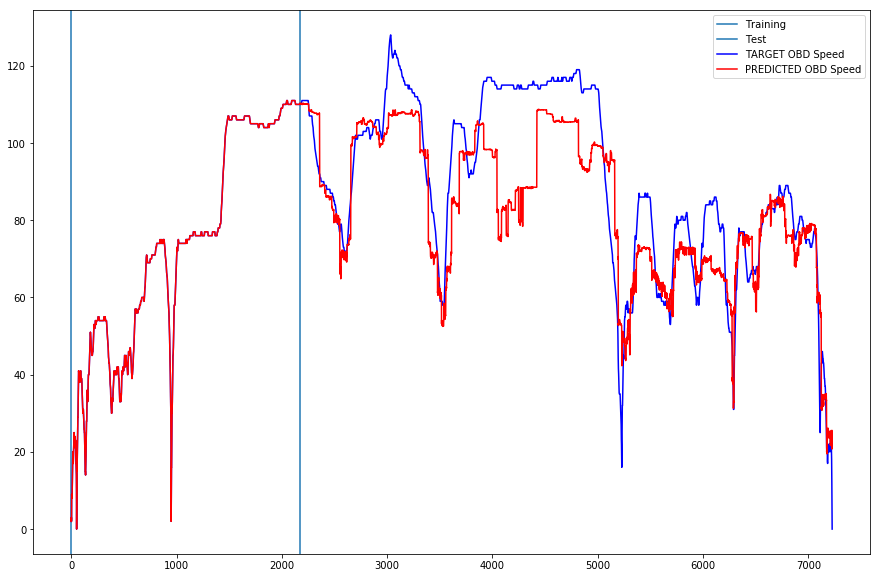

In [15]:
xaxis = range(0, TEST_RANGE[1])
plot.figure(figsize=(15,10))
plot.axvline(x=TRAINING_RANGE[0])
plot.axvline(x=TRAINING_RANGE[1])
plot.plot(xaxis, target, 'b', xaxis, clf.predict(data), 'r')
plot.legend(['Training','Test','TARGET OBD Speed','PREDICTED OBD Speed'])

Anscheinend wird immer die höchste Geschwindigkeit vorrausgesagt, die der Regressor je gesehen hat. Wird er beispielsweise mit einer Landstraßenfahrt trainiert, ist auch auf der Autobahn bei 100 km/h Schluss.

<BarContainer object of 311 artists>

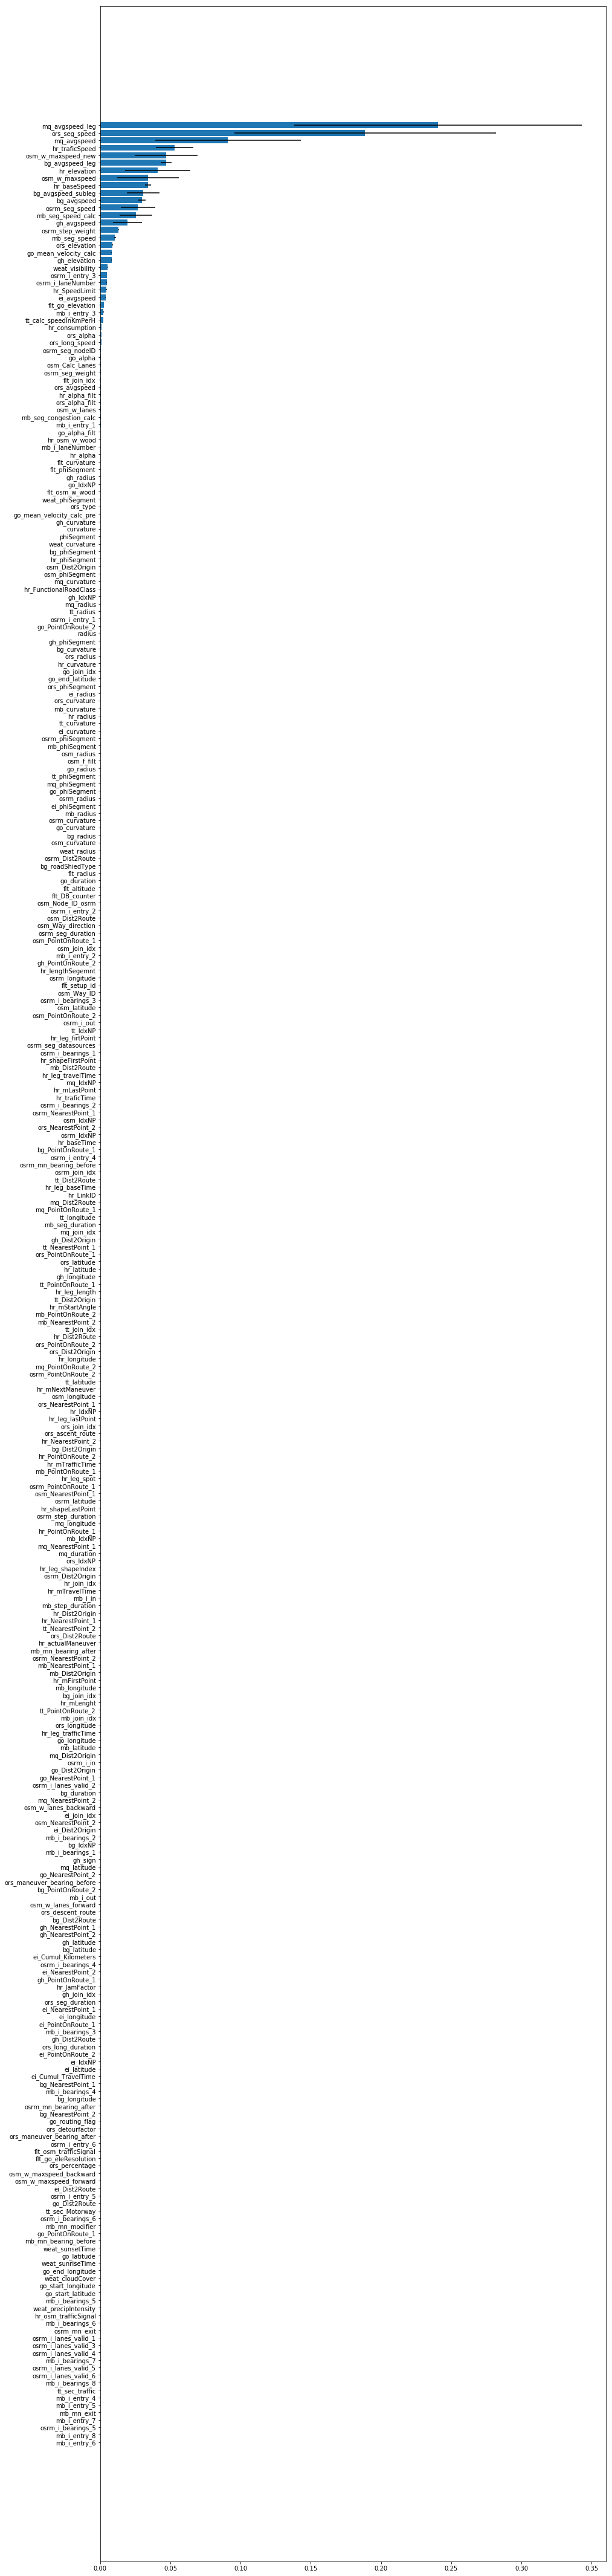

In [16]:
plot.figure(figsize = (15, 0.25 * len(DATA_COLUMNS)))
importances = clf.best_estimator_.feature_importances_
stddev = np.var([t.feature_importances_ for t in clf.best_estimator_.estimators_], axis = 0)
sorted_indices = np.argsort(importances)
plot.barh(np.array(DATA_COLUMNS)[sorted_indices], importances[sorted_indices], xerr = stddev[sorted_indices])

Einige der Top-Features sprachen für starkes Overfitting:
- Temperatur und Luftfeuchtigkeit (`weat_temperature`, `weat_humidity`) bewegen kleinem Rahmen, und sollten auf das Fahrverhalten nur bedingten Einfluss haben (wenn überhaupt, nur auf längere Sicht gesehen; z.B. langsameres Fahren bei schlechtem Wetter).
- `join_idx` macht keinen Sinn.
- Position (Breiten- und Längengrad: `flt_latitude`, `latitude`, `longitude`, `flt_longitude`) funktionieren nur auf einer spezifischen Strecke. Das Lernen von Eigenheiten dieser Strecke ist nicht Aufgabe des Regressors; das sollte höchstens in anderen Datenquellen gespeichert und dann zur Berechnung hergezogen werden.
- Zeit und Entfernung (`hr_remainDistance`, `tt_calc_distance`, `ei_distance_lldist`, `hr_distance_lldist`, `gh_distance_lldist`, `time` etc.) sind schlecht auf andere Fahrten übertragbar; würde ich dieselbe Strecke von einem anderen Ausgangspunkt aus fahren, wäre die gesamte Vorhersage verschoben
- Windrichtung (`weat_windBearing`) hätte durchaus einen Einfluss (Rücken-/Gegenwind), allerdings nur, wenn die aktuelle Fahrtrichtung auch verwendet wird

Diese Features wurden daher ausgeschlossen, was zu einer merklichen Verbesserung der Prädiktion führt (ist nun besser als HERE Maps in nahezu allen verwendeten Kriterien).

Interessanterweise scheinen die Bäume allerdings vor allem eine Aggregation verschiedener Quellen für die Durchschnittsgeschwindigkeit zu sein …

# Gütekriterium - Prädiktion

Berechung des Gütekritierums
- Root-mean-square deviation RMSE
- NRMSE Normalized root-mean-square deviation
- Mean absolute error MAE
- Mean absolute percentage error MAP
- Symmetric mean absolute percentage error
- https://en.wikipedia.org/wiki/Least_absolute_deviations
- https://en.wikipedia.org/wiki/Mean_signed_deviation
- Pearson Correlation Coefficient
- Accuracy (Interval of given size; absolute and relative)
- Median Absolute Deviation

BITTE weitere Kriterien ergänzen


In [17]:
ta = target[TEST_RANGE[0]:TEST_RANGE[1]]
pr = clf.predict(data[TEST_RANGE[0]:TEST_RANGE[1]])
RMSE = math.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 12.96 km/h
NRMSE = 43.53 %
MAE   = 9.77 km/h
MAP   = 11.39 %
SMAPE = 11.60 %
MSD   = 6.06 km/h
CORR  = 0.87
ACC_A = 59.66 %
ACC_R = 53.50 %
MAD   = 7.29 km/h


# Vergleich mit HERE Maps Trafic Speed
Kann zum Vergleich sehr gut herangezogen werden ;)

In [18]:
ta = target[TEST_RANGE[0]:TEST_RANGE[1]]
pr = t['hr_traficSpeed']
pr = pr[TEST_RANGE[0]:TEST_RANGE[1]] * 3.6
RMSE = math.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 16.82 km/h
NRMSE = 26.73 %
MAE   = 14.06 km/h
MAP   = 15.87 %
SMAPE = 16.62 %
MSD   = 9.82 km/h
CORR  = 0.81
ACC_A = 40.18 %
ACC_R = 32.00 %
MAD   = 12.84 km/h


# Generalisierbarkeit

Nach der abgeschlossenen Fahrt wird mit der ganzen Fahrt trainiert, und anschließend eine andere Fahrt vorhergesagt. Als Parameter werden die gefundenen Parameter der Grid Search beim ersten mal verwendet, wodurch sich der Vorgang erheblich beschleunigt.

In [19]:
clf2 = ExtraTreesRegressor(n_estimators = clf.best_params_['n_estimators'],
                          max_depth = clf.best_params_['max_depth'],
                          max_features = clf.best_params_['max_features'])
clf2.fit(data, target)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=20,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

<BarContainer object of 311 artists>

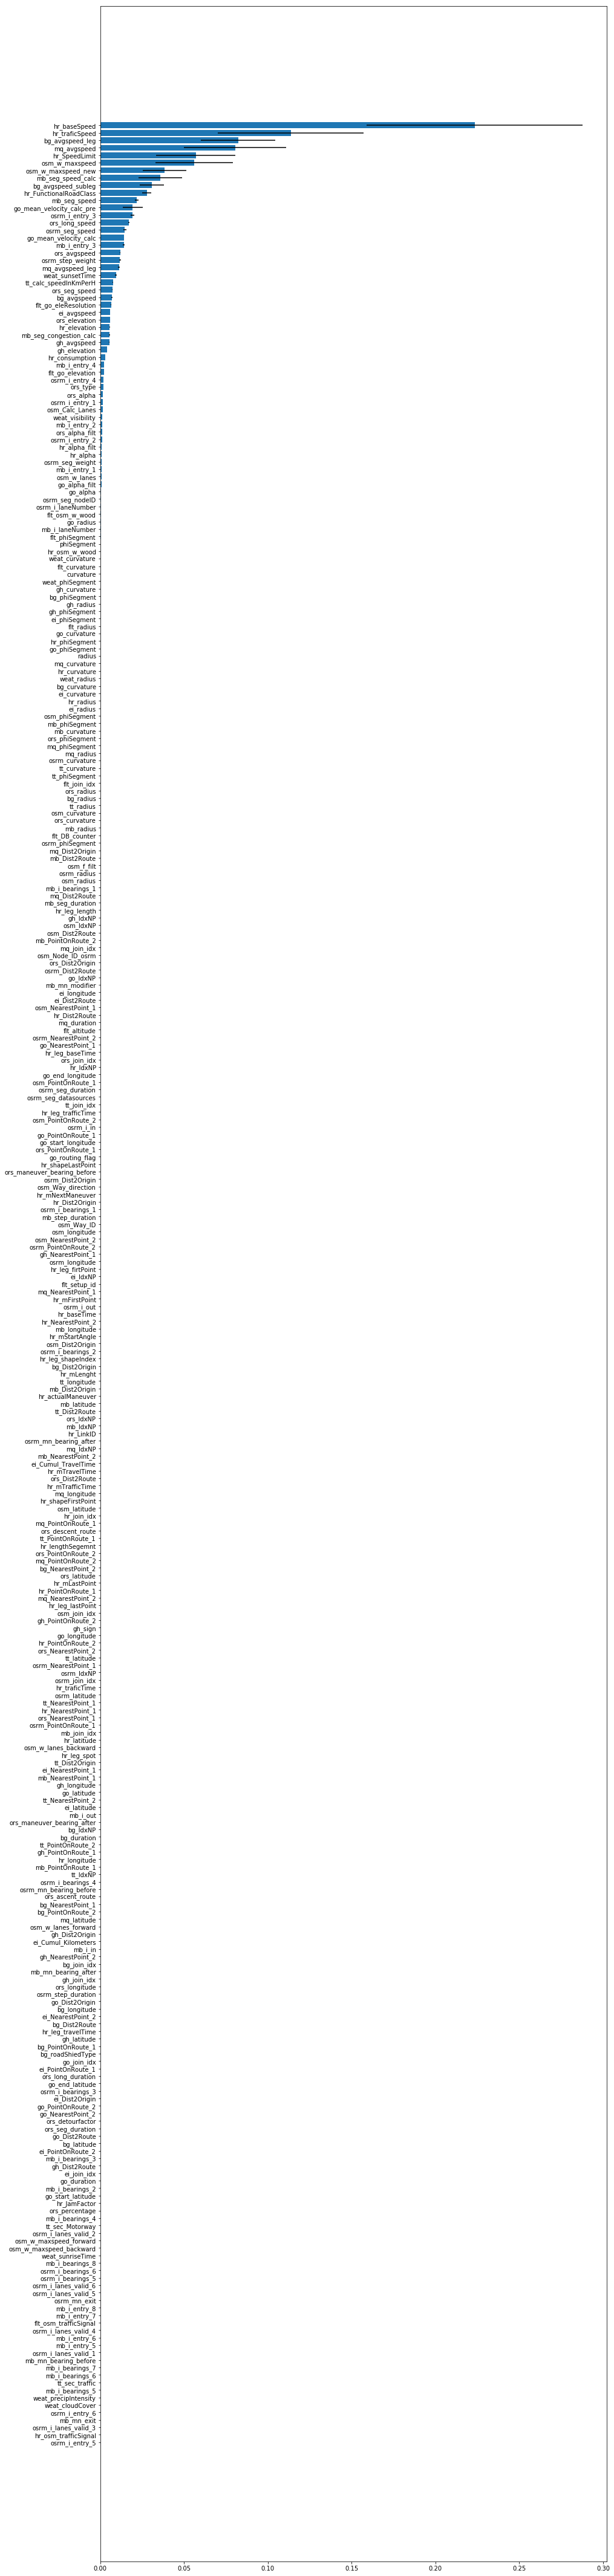

In [20]:
plot.figure(figsize = (15, 0.25 * len(DATA_COLUMNS)))
importances = clf2.feature_importances_
stddev = np.var([t.feature_importances_ for t in clf2.estimators_], axis = 0)
sorted_indices = np.argsort(importances)
plot.barh(np.array(DATA_COLUMNS)[sorted_indices], importances[sorted_indices], xerr = stddev[sorted_indices])

In [21]:
SETUP_ID_2 = 450

reader2 = runsql('select * from computeddata where setup_id = {} order by distance asc'.format(SETUP_ID_2))
reader_data2 = list(reader2) # list(...) so that following cells can be repeated

In [22]:
data2 = []
target2 = []
for row in reader_data2:
    data2 += [[float(row[c]) if row[c] != '' else math.nan for c in DATA_COLUMNS]]
    target2 += [float(row[TARGET_COLUMN]) if row[TARGET_COLUMN] != '' else math.nan]

In [23]:
data2 = imp.transform(data2)

In [24]:
np.savetxt('imputed-{}.csv'.format(SETUP_ID_2), data2, delimiter=',')
np.savetxt('target-{}.csv'.format(SETUP_ID_2), target2, delimiter=',')

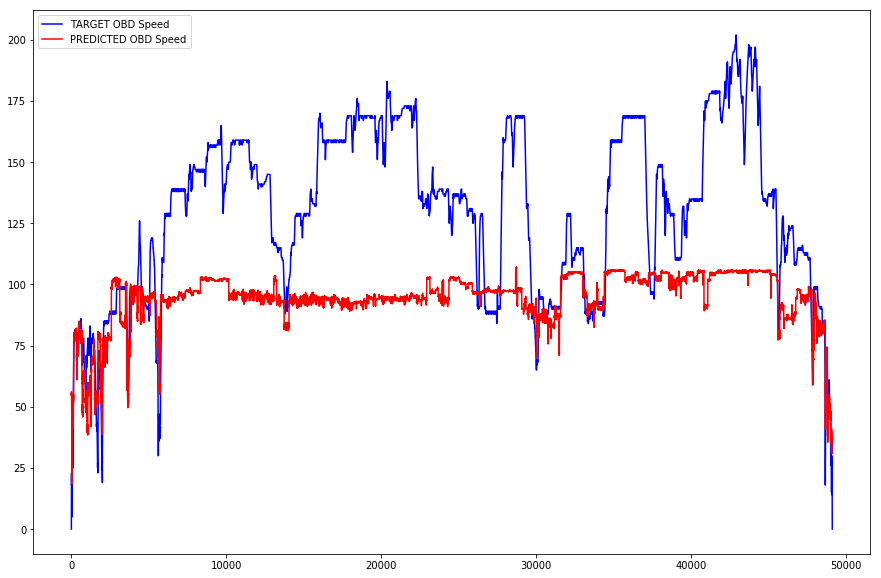

In [23]:
plot.figure(figsize=(15,10))
xaxis = range(0, len(target2))
plot.plot(xaxis, target2, 'b', xaxis, clf2.predict(data2), 'r')
plot.legend(['TARGET OBD Speed','PREDICTED OBD Speed'])

Wie bereits vorher festgestellt, scheint der Regressor mit höheren Geschwindigkeiten nicht vertraut. Trainieren wir also mit diesem Datensatz einen weiteren Regressor, und testen wieder mit einem anderen.

In [24]:
clf3 = ExtraTreesRegressor(n_estimators = clf.best_params_['n_estimators'],
                          max_depth = clf.best_params_['max_depth'],
                          max_features = clf.best_params_['max_features'])
clf3.fit(data2, target2)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

<BarContainer object of 311 artists>

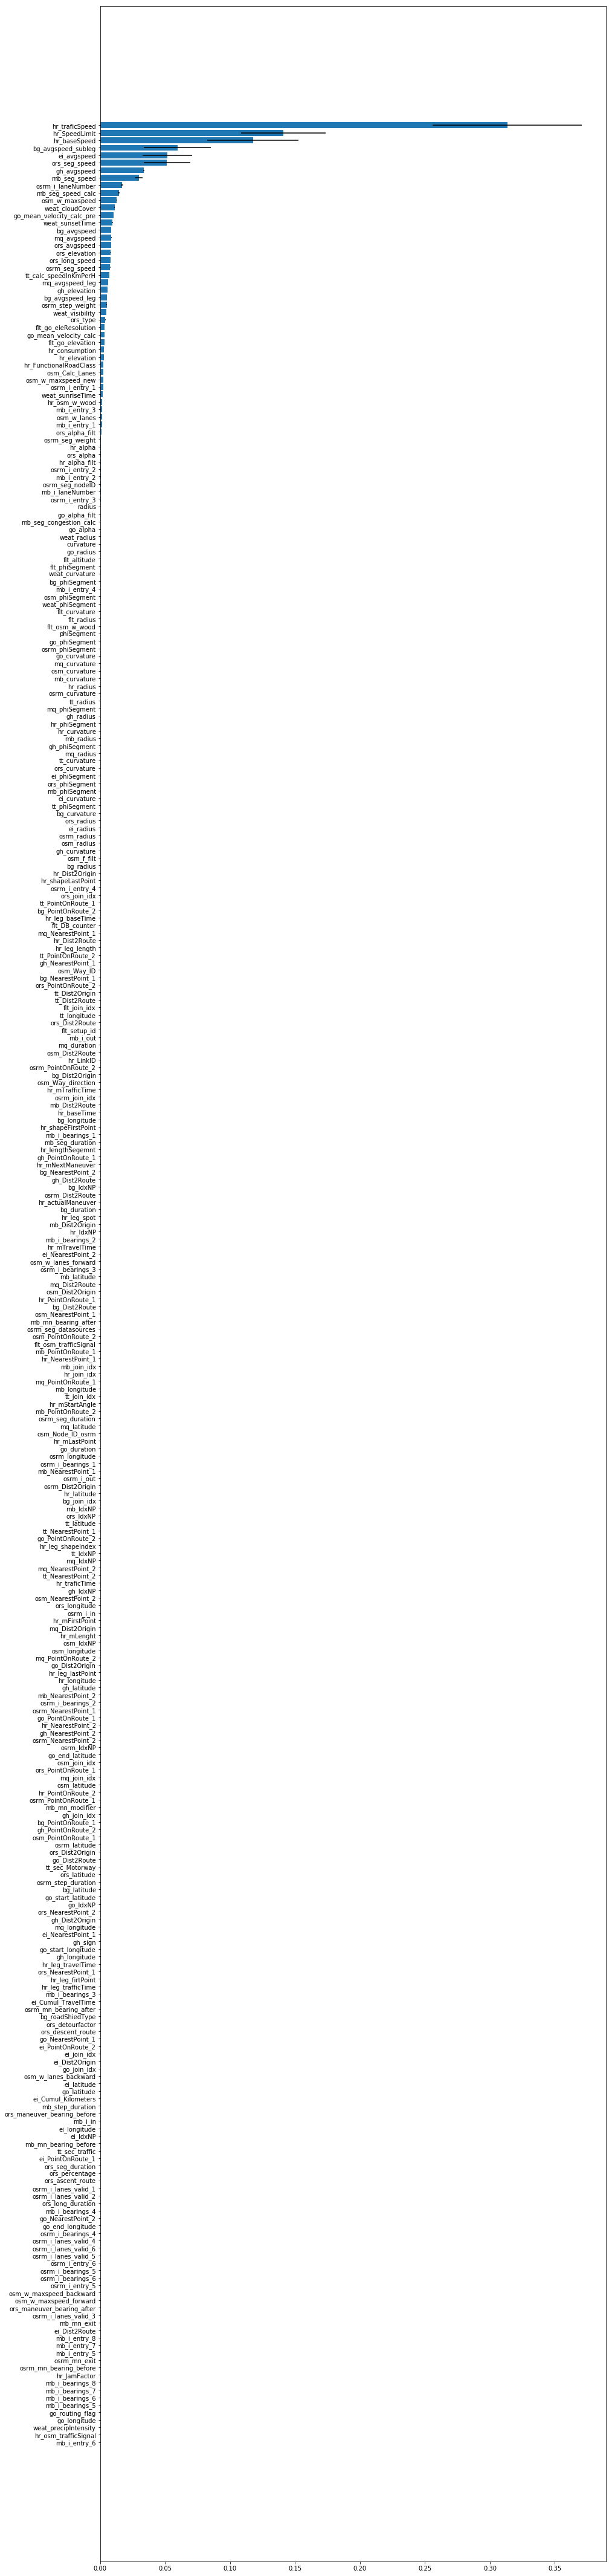

In [25]:
plot.figure(figsize = (15, 0.25 * len(DATA_COLUMNS)))
importances = clf3.feature_importances_
stddev = np.var([t.feature_importances_ for t in clf3.estimators_], axis = 0)
sorted_indices = np.argsort(importances)
plot.barh(np.array(DATA_COLUMNS)[sorted_indices], importances[sorted_indices], xerr = stddev[sorted_indices])

In [26]:
SETUP_ID_3 = 888

reader3 = runsql('select * from computeddata where setup_id = {} order by distance asc'.format(SETUP_ID_3))
reader_data3 = list(reader3) # list(...) so that following cells can be repeated

In [27]:
data3 = []
target3 = []
for row in reader_data3:
    data3 += [[float(row[c]) if row[c] != '' else math.nan for c in DATA_COLUMNS]]
    target3 += [float(row[TARGET_COLUMN]) if row[TARGET_COLUMN] != '' else math.nan]

In [28]:
data3 = imp.transform(data3)

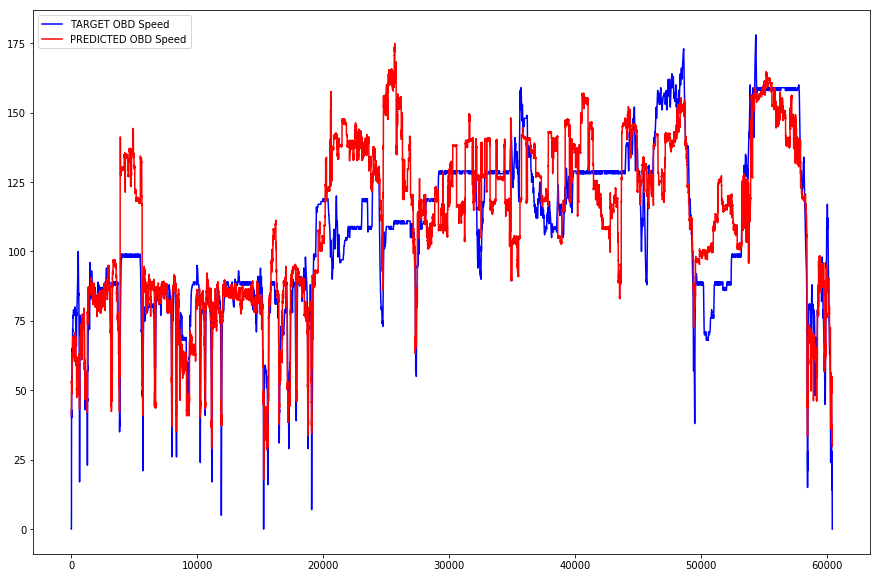

In [29]:
plot.figure(figsize=(15,10))
xaxis = range(0, len(target3))
plot.plot(xaxis, target3, 'b', xaxis, clf3.predict(data3), 'r')
plot.legend(['TARGET OBD Speed','PREDICTED OBD Speed'])

Wir vergleichen die Prädiktion mit HERE Maps:

In [30]:
ta = target3
pr = clf3.predict(data3)
RMSE = math.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 18.76 km/h
NRMSE = 34.58 %
MAE   = 14.18 km/h
MAP   = 14.16 %
SMAPE = 13.26 %
MSD   = -3.92 km/h
CORR  = 0.80
ACC_A = 47.99 %
ACC_R = 51.85 %
MAD   = 10.45 km/h


In [31]:
ta = target3
pr = np.array([float(d['hr_traficSpeed']) if d['hr_traficSpeed'] != '' else 0.0 for d in reader_data3])
pr = pr * 3.6
RMSE = math.sqrt(sum((ta-pr)**2)/len(ta))
print("RMSE  = %.2f km/h" %RMSE)
NRMSE = 1-math.sqrt(sum((ta-pr)**2))/math.sqrt(sum( (ta-np.mean(ta) )**2 ))
print("NRMSE = %.2f %%" %(NRMSE*100))
MAE = sum(((ta-pr)**2)**(1/2))/len(ta)
print("MAE   = %.2f km/h" %MAE)
with np.errstate(divide = 'ignore'): map_elements = np.abs((ta - pr) / ta)
map_elements[map_elements == np.inf] = 0
MAP = np.sum(map_elements) / len(ta)
print("MAP   = %.2f %%" % (MAP*100))
SMAPE = np.sum(np.abs(ta - pr) / ((ta + pr) / 2)) / len(ta)
print("SMAPE = %.2f %%" % (SMAPE*100))
MSD = np.sum(ta - pr) / len(ta)
print("MSD   = %.2f km/h" % MSD)
CORR = np.corrcoef(ta, pr)[1][0]
print("CORR  = %.2f" % CORR)
ACC_A_THRESHOLD = 10
ACC_A = (np.abs(ta - pr) < ACC_A_THRESHOLD).sum() / len(ta)
print("ACC_A = %.2f %%" % (ACC_A*100))
ACC_R_THRESHOLD = 0.1
ACC_R = (np.abs(ta / pr - 1) < ACC_R_THRESHOLD).sum() / len(ta)
print("ACC_R = %.2f %%" % (ACC_R*100))
MAD = np.median(np.abs(ta - pr))
print("MAD   = %.2f km/h" % MAD)

RMSE  = 21.57 km/h
NRMSE = 24.75 %
MAE   = 16.79 km/h
MAP   = 14.52 %
SMAPE = 15.78 %
MSD   = 12.98 km/h
CORR  = 0.81
ACC_A = 42.47 %
ACC_R = 35.90 %
MAD   = 12.00 km/h


In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[TRAINING_RANGE[0]:TRAINING_RANGE[1]])

scaled_training_data = scaler.transform(data[TRAINING_RANGE[0]:TRAINING_RANGE[1]])
scaled_data = scaler.transform(data)
scaled_target = np.multiply(target, 0.01)

In [55]:
def gridsearch_train_and_plot(base, params = {}):
    best_clf = gridsearch(base, params)
    best_clf.fit(scaled_training_data, scaled_target[TRAINING_RANGE[0]:TRAINING_RANGE[1]])
    xaxis = range(0, TEST_RANGE[1])
    print(best_clf.best_params_)
    plot.figure(figsize=(15,10))
    plot.axvline(x=TRAINING_RANGE[0])
    plot.axvline(x=TRAINING_RANGE[1])
    plot.plot(xaxis, scaled_target, 'b', xaxis, best_clf.predict(scaled_data), 'rx')
    plot.legend(['Training','Test','TARGET OBD Speed','PREDICTED OBD Speed'])

/home/markus/Studium/IDP/repo/Python/_venv/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{}


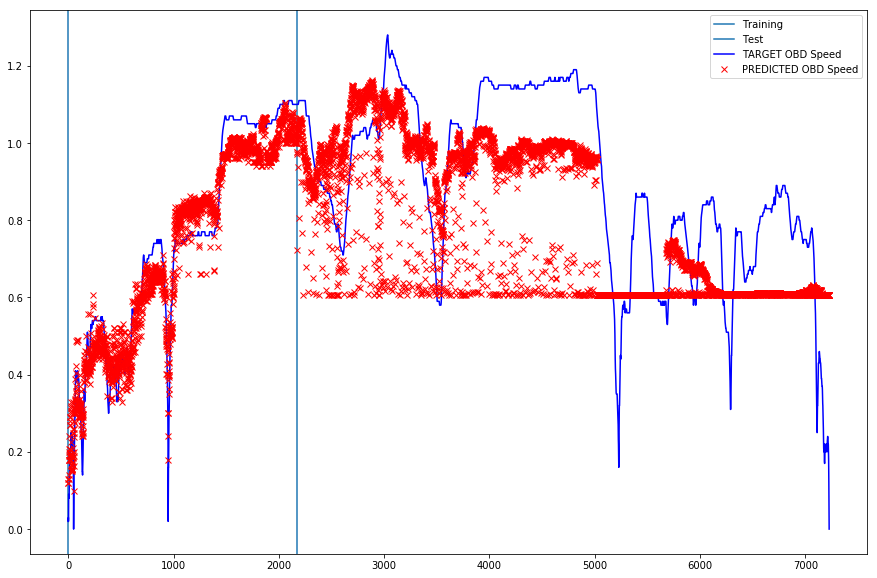

In [58]:
from sklearn import svm
gridsearch_train_and_plot(svm.SVR())

/home/markus/Studium/IDP/repo/Python/_venv/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{}


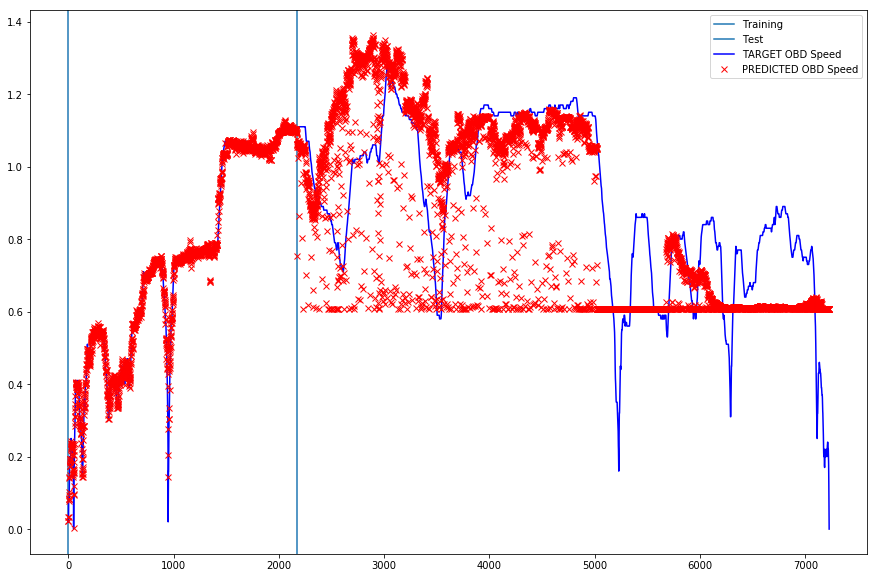

In [59]:
gridsearch_train_and_plot(svm.NuSVR())

/home/markus/Studium/IDP/repo/Python/_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/markus/Studium/IDP/repo/Python/_venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'loss': 'huber'}


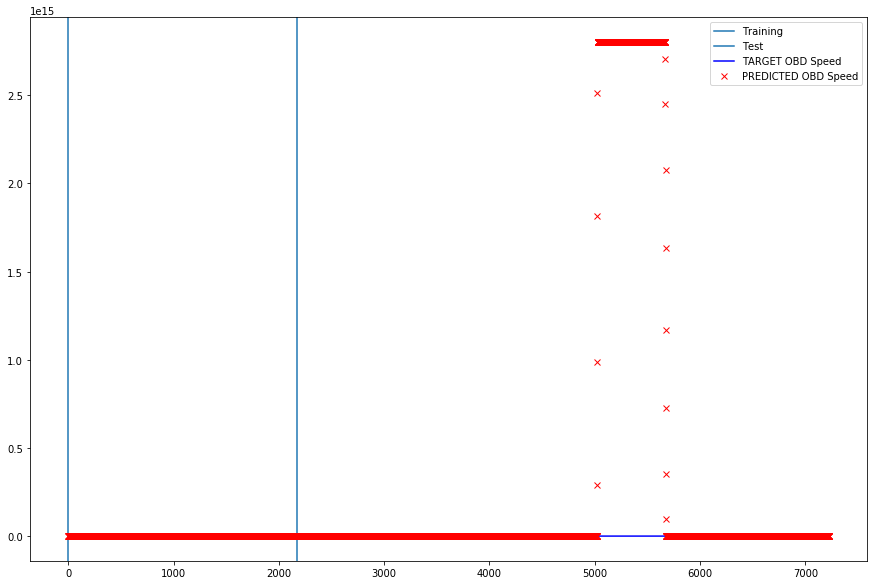

In [57]:
from sklearn import linear_model
gridsearch_train_and_plot(linear_model.SGDRegressor(),
                          {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']})

{'n_neighbors': 10, 'weights': 'distance'}


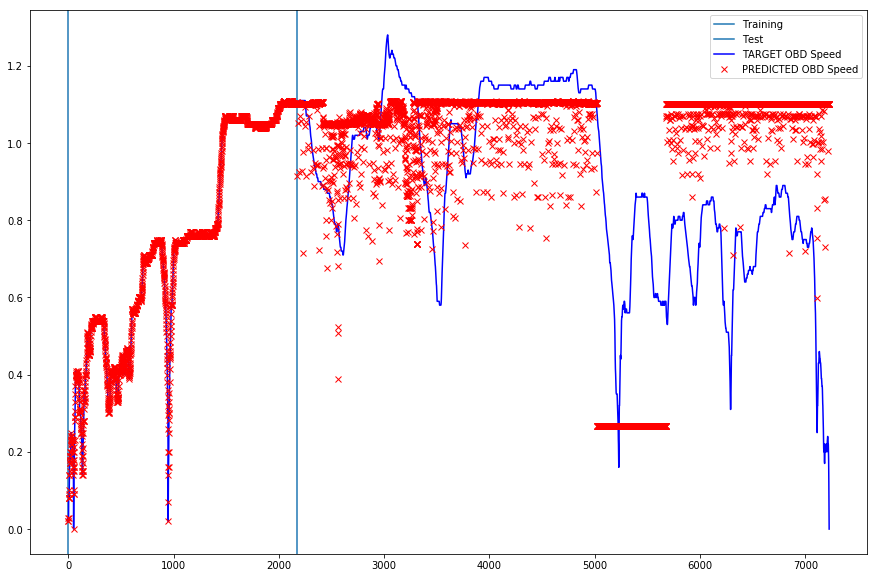

In [62]:
from sklearn import neighbors
gridsearch_train_and_plot(neighbors.KNeighborsRegressor(),
                         {'n_neighbors': [5, 10, 20, 50, 100, 200, 500],
                          'weights': ['uniform', 'distance']})

In [61]:
# i think something is borked in there
gridsearch_train_and_plot(neighbors.RadiusNeighborsRegressor(),
                         {'radius': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0],
                          'weights': ['uniform', 'distance']})

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

/home/markus/Studium/IDP/repo/Python/_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'normalize_y': True}


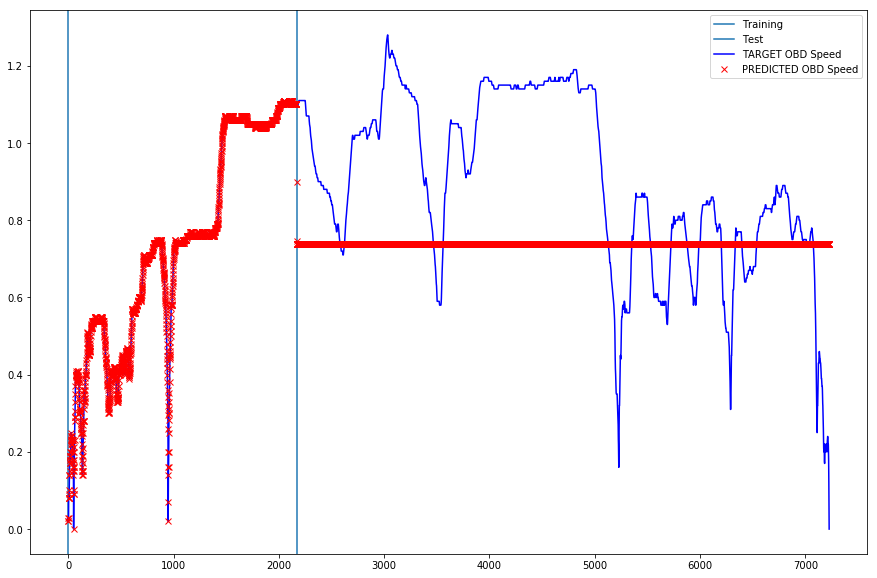

In [63]:
from sklearn import gaussian_process
gridsearch_train_and_plot(gaussian_process.GaussianProcessRegressor(),
                         {'normalize_y': [True, False]})